In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import gc

import os
import sys

from app.historical_price import HistoricalPrice
from app.random_variable import RandomVariable
pd.set_option('display.max_rows', None)

In [2]:
hp = HistoricalPrice()
returns = hp.get_all_returns(freq='monthly')
print(returns.shape)

(201, 678)


In [3]:
## Skewness test
### STRATEGY, focus on negatively skewed assets
### In general they give small positive returns
### but once in a while they could result in large losses.

### We want to hold generally good stocks that are increasing in value,
### but if we can predict when these rare large losses occur then we can make a profit.

### However we need to limit losses.
### The asset returns (especially the loss tail) must be uncorrelated, 
### to limit exposure.

skew = pd.DataFrame(None,columns=['statistic','pvalue'])

for stock in returns.columns:
    skew.loc[stock,:] = stats.skewtest(returns[stock].dropna())
skew = skew.sort_values(by=['statistic'],ascending=False)
print(skew.loc[skew['statistic']>0].dropna().shape[0],len(skew))
print(skew.head())
print(skew.tail())

648 678
     statistic pvalue
KHP  12.942871    0.0
PMS   12.61471    0.0
CMS  12.394908    0.0
C32  12.336209    0.0
SRA  12.160363    0.0
    statistic    pvalue
VRE -1.780396  0.075011
LM8    -1.796  0.072495
DS3 -2.326351      0.02
AST -3.485124  0.000492
SHP -4.495437  0.000007


In [13]:
from scipy.stats import gennorm, laplace_asymmetric,laplace,skewnorm

 # MSN, VNM, MIG, LIX, DHG 
r = hp.returns("PLX",'daily')['r'].values[500:]

for d in [skewnorm, gennorm,laplace_asymmetric,laplace]:
    params = d.fit(r)
    print(params)
    print(np.sum(np.log(d.pdf(r,*params))))
    
# dgamma has highest ll (but probably overfit)
## gennorm is best choice overall 

(-1.1183860012450153, 0.014049238389896827, 0.024242323009231917)
2967.887344987367
(0.754468540401481, 1.1649762471388312e-11, 0.008048545226969888)
3100.113082435033
(1.0097480990048162, -3.792769552444605e-09, 0.013319319114902835)
3090.0052477704244
(0.0, 0.013321505980459704)
3089.893801029415


### Distribution of returns

In [17]:
### Quick test of different distributions 
from distfit import distfit
dfit = distfit(todf=True,verbose=False,method='parametric',distr='full')

dist = pd.DataFrame(None,index=returns.columns,columns=["first","second","third","fourth",'fifth'])
for stock in returns.sample(20,axis=1).columns:
    results = dfit.fit_transform(returns[stock].dropna())
    dist.loc[stock,:] = results['summary'].iloc[0:5].name.values

dist.shape

(678, 5)

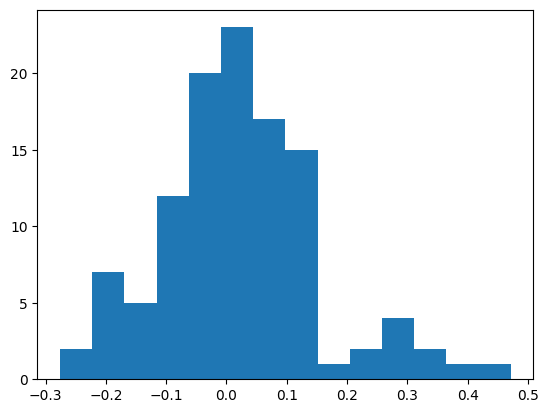

In [9]:
# stock = dist[dist=='t'].sample(n=1).index[0]
# print(stock, returns['TCB'].dropna().shape)
plt.hist(returns['VSI'], bins='auto')
plt.show()

In [ ]:
from scipy.stats import nct, laplace_asymmetric , t, laplace, genhyperbolic

test = 'SSI'
### MAXIMUM LOGLIKELIHOOD, the higher the better
for d in [nct, laplace_asymmetric , t, laplace, genhyperbolic]:
    params = d.fit(returns[test].dropna())
    log_likelihood = np.sum(np.log(d.pdf(returns[test].dropna(),*params)))
    print(d)
    print(params)
    print(log_likelihood,"\n")

NCT is a generalization of t and Asymmetrical Laplace is a generalization of Laplace, so they will always have higher MLE.

Even the NCT and Asym Laplace wont be able to fit the data perfectly, so is it better just to use empirical distribution for CVaR calculation?

Parametric is still preferable because for each asset the sample size is not large enough, so the parametric distribution is also for interpolation. With Laplace and T we can obtain closed form formula for CVaR.

However most assets have skewed returns so the NCT and Asym Laplace will be more accurate estimation. The only problem is that we would have use Monte Carlo distribution to estimate the CVaR.

However, the Generalized Hyperbolic distribution is even better for asset returns. This distribution is a generalzation of the NCT and Asym Laplace so it is more 
flexible. 

### Comparing Student T, Asym Laplace, and Generalized Hyperbolic for all stocks

In [ ]:
mle = pd.DataFrame(None,columns=['mle_alp','mle_nct','mle_gh','params_alp','params_nct','params_gh'])
for stock in returns.columns:
    r = returns[stock].dropna()
    alp_params = laplace_asymmetric.fit(r)
    nct_params = nct.fit(r)
    gh_params = genhyperbolic.fit(r)
    
    mle_alp = np.sum(np.log(laplace_asymmetric.pdf(r,*alp_params)))
    mle_nct = np.sum(np.log(nct.pdf(r,*nct_params[0])))
    mle_gh = np.sum(np.log(genhyperbolic.pdf(r,*gh_params[0])))
    
    mle.loc[stock,:] = [mle_alp,mle_nct,mle_gh,alp_params,nct_params,gh_params]

In [ ]:
print(mle.loc[mle['mle_alp']<mle['mle_gh']].shape)
print(mle.loc[mle['mle_nct']<mle['mle_gh']].shape)
print(mle.loc[mle['mle_nct']<mle['mle_alp']].shape)
mle.head()

### Overall Generalized Hyperpolic > Asym Laplace > NCT
### This makes sense because Generalized Hyperpolic is a generalization of 
### the other distributionss

___
___
___

## Modelling dependencies with copulas

In [20]:
returns.shape

(201, 678)

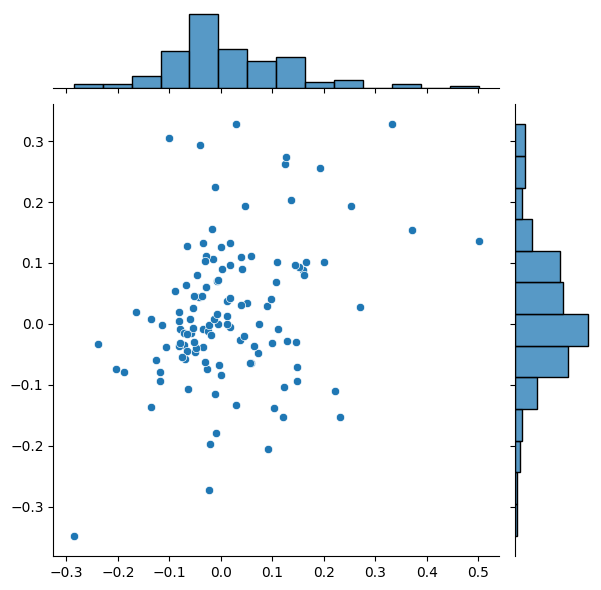

In [21]:
import seaborn as sns

pair = ['MSN','VIC']

X = returns.loc[:,pair].dropna().values
sns.jointplot(x=X[:,0],y=X[:,1])

In [22]:
stock1 = RandomVariable(X[:,0],gennorm)
stock2 = RandomVariable(X[:,1],gennorm)
stock1.mle(),stock2.mle()

(92.09715502110492, 91.8422457615742)

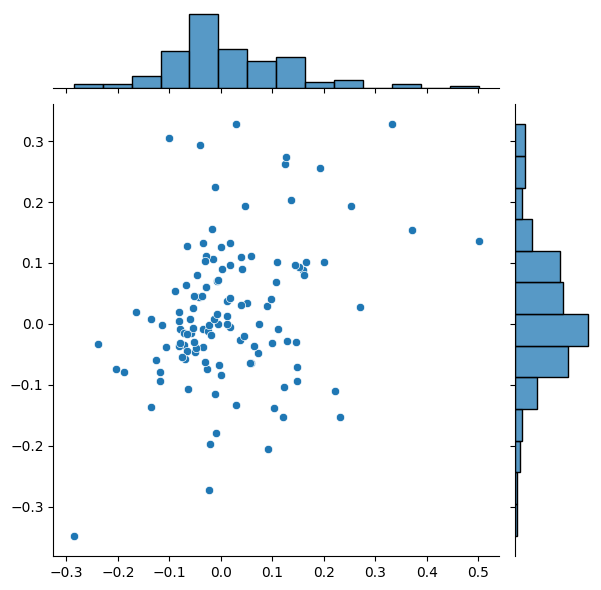

In [23]:
sns.jointplot(x=stock1.data,y=stock2.data)

In [20]:
u1 = stock1.unif()
u2 = stock2.unif()

(1348,)


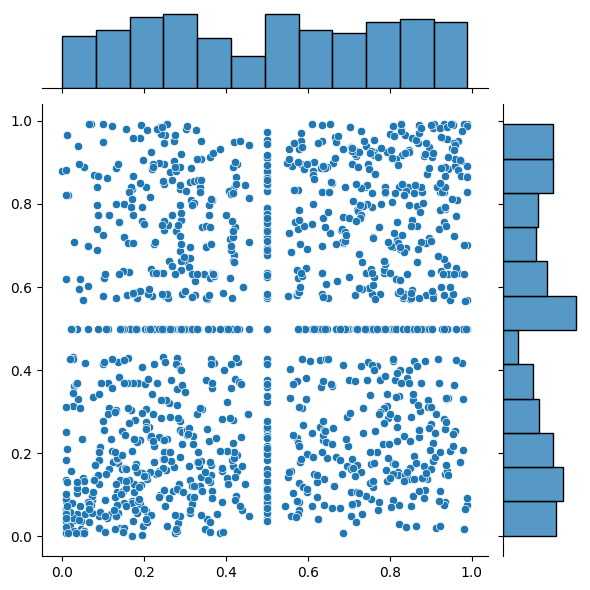

In [21]:
print(u1.shape)
sns.jointplot(x=u1,y=u2)

In [24]:
import pyvinecopulib as pv

data = pd.DataFrame(np.vstack((u1,u2)).T,columns=pair)
cop = pv.Vinecop(data=data)
print(cop.loglik(),cop.aic())


#### loklik the higher the better
### AIC the smaller the better
cop
##1983.1268456794094 -3881.5997679050834  asym_laplace
## 1985.256394104031 -3885.875608856917 gennorm
## 1938.7358558004396 -3873.471711600879 norm 
## 1915.265963090033 -3826.531926180066 dgamma

NameError: name 'u1' is not defined

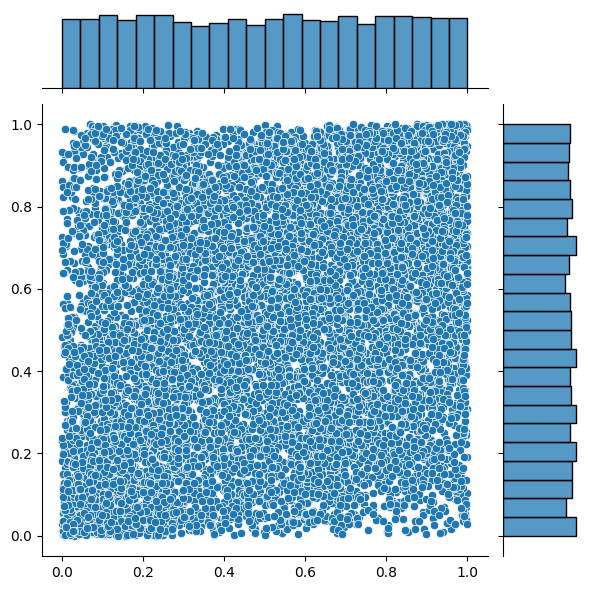

In [23]:
sample = cop.simulate(n=10000,num_threads = 100)
sns.jointplot(x=sample[:,0],y=sample[:,1])

In [24]:
t1= stock1.transform(sample[:,0])
t2 = stock2.transform(sample[:,1])

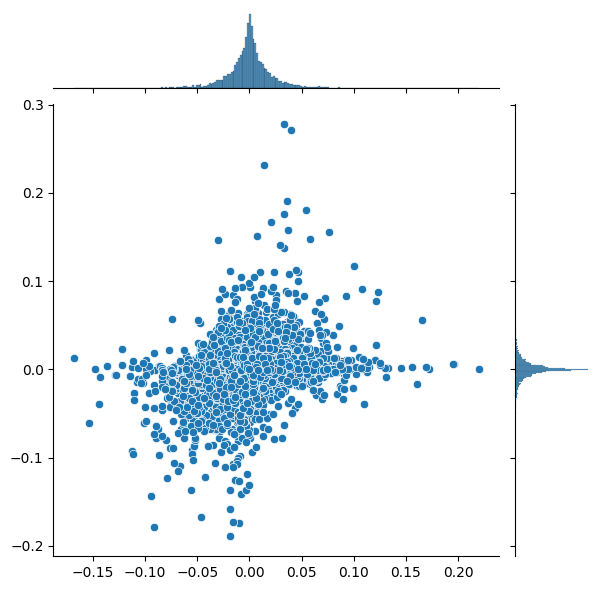

In [25]:
del u1, u2, stock1, stock2, data, sample, cop
gc.collect()

t1 = np.float32(t1)
t2 = np.float32(t2)
sns.jointplot(x=t1,y=t2)

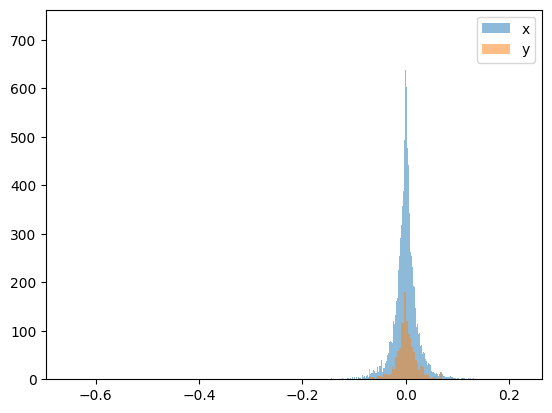

In [26]:
plt.hist(t1, bins='auto', alpha=0.5, label='x')
plt.hist(X[:,0], bins='auto', alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.show()

### Measuring non-linear Correlation with Kendall tau

#### Cross-correlation with no lags

In [27]:
corr = returns.corr(method='kendall')
corr.shape

(392, 392)

In [28]:
corr.head()

,NHA,DCM,PDN,S4A,TCO,ASG,GVR,VHC,FRT,CRC,...,REE,NAV,VCB,CTG,DBT,SBA,FIR,LBM,GAS,DHA
NHA,1.000000,0.108341,-0.008656,0.039178,0.030935,0.054455,0.220026,0.086547,0.161994,0.165562,...,0.126708,0.027823,0.106713,0.125629,0.067181,0.085289,0.154150,0.052070,0.096849,0.095867
DCM,0.108341,1.000000,0.023413,0.036792,0.050398,0.089838,0.210387,0.193257,0.233149,0.100296,...,0.202324,0.015965,0.133586,0.164018,0.078880,0.067789,0.156233,0.019469,0.170966,0.124565
PDN,-0.008656,0.023413,1.000000,0.020026,0.008542,-0.062360,0.008924,0.002816,0.004307,0.000876,...,0.021051,0.009285,0.013971,0.005690,0.001920,0.024359,-0.014514,0.016494,0.029635,0.002335
S4A,0.039178,0.036792,0.020026,1.000000,0.033178,0.003187,0.025394,0.042197,0.005862,0.049641,...,0.046503,0.016767,0.046663,0.047267,0.007512,0.030562,0.047294,0.019010,0.046067,0.035453
TCO,0.030935,0.050398,0.008542,0.033178,1.000000,0.026605,0.056599,0.029906,0.062749,0.089874,...,0.052550,0.007526,0.051426,0.054446,0.007088,0.041999,0.090606,0.028836,0.030941,0.033197


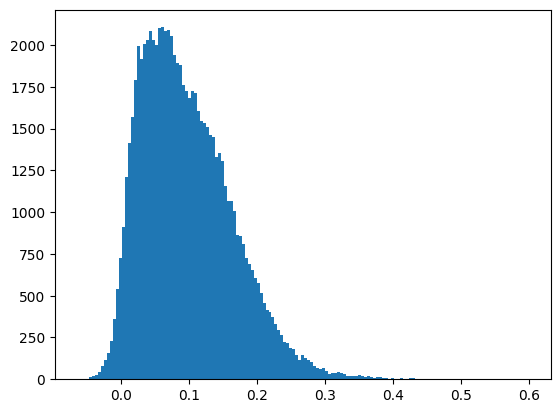

In [29]:
upper_triangle_corrs = np.triu(corr.values).flatten()
upper_triangle_corrs = upper_triangle_corrs[(upper_triangle_corrs!=0)&(upper_triangle_corrs!=1)]
plt.hist(upper_triangle_corrs, bins='auto')
plt.show()

## below is a histogram of kendall correlation between all assets pair
# in general assets are more positively correlated.
## The histogram is positive skewed also.

In [ ]:
### >= 0.5 (strong), 0.5 >= 0.35 (moderate) 
strong_corr = corr.sample(frac=1, axis=1).sample(frac=1,axis=0)[(0.4<=np.abs(corr))&(np.abs(corr)<1)].sample(frac=1, axis=1).sample(frac=1,axis=0)
sample = 0 

for r in strong_corr.index:
    for c in strong_corr.columns:
        if not np.isnan(strong_corr.loc[r,c]):
            n = len(returns.loc[:,[r,c]].dropna(axis=0))
            if n >= 52 and sample<4:
                sample+=1
                print(r,c,strong_corr.loc[r,c])
                plt.figure(figsize=(3,3))
                plt.scatter(returns[r], returns[c])
                plt.show()

#### Correlation with lags (max 2 lags only [0,1,2])

In [7]:
hp = HistoricalPrice()
FREQ = 'daily'
returns = hp.get_returns(freq=FREQ)
print(returns.shape)

(5497, 663)


In [8]:
for lag in range(0,2):
    returns_lag = returns.shift(lag)
    corr = hp.get_corr(returns,returns_lag)
    df_corr = pd.DataFrame.from_dict(corr,orient='index')
    df_corr.columns = ['kendall','p_value']
    df_corr.to_csv(f'data/{FREQ}_returns_kendall_correlation_lag{lag}.csv')
"DONE"

'DONE'